# Different Algorithms of Linear Regression using SystemML

In [2]:
!pip install --upgrade systemml


    100% |████████████████████████████████| 10.5MB 118kB/s eta 0:00:01
    100% |████████████████████████████████| 12.1MB 92kB/s  eta 0:00:01
    100% |████████████████████████████████| 49.7MB 25kB/s  eta 0:00:01    38% |████████████▍                   | 19.2MB 10.3MB/s eta 0:00:03    88% |████████████████████████████▎   | 43.9MB 39.8MB/s eta 0:00:01
    100% |████████████████████████████████| 25.7MB 45kB/s  eta 0:00:01    63% |████████████████████▎           | 16.3MB 71.3MB/s eta 0:00:01
Requirement already up-to-date: scikit-learn in /usr/local/src/conda3_runtime.v29/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages (from systemml)
    100% |████████████████████████████████| 2.0MB 628kB/s eta 0:00:01
    100% |████████████████████████████████| 215kB 4.9MB/s eta 0:00:01
    100% |████████████████████████████████| 512kB 2.4MB/s eta 0:00:01
Requirement already up-to-date: six>=1.5 in /usr/local/src/conda3_runtime.v29/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages (from 

In [3]:
!pip show systemml

Name: systemml
Version: 1.1.0
Summary: Apache SystemML is a distributed and declarative machine learning platform.
Home-page: http://systemml.apache.org/
Author: Apache SystemML
Author-email: dev@systemml.apache.org
License: Apache 2.0
Location: /gpfs/global_fs01/sym_shared/YPProdSpark/user/s11c-a06657ba84995c-faf8bfcc79bc/.local/lib/python3.5/site-packages
Requires: scipy, numpy, Pillow, scikit-learn, pandas


In [4]:
sc.version

'2.1.2'

In [6]:
from systemml import MLContext, dml
ml=MLContext(sc)
print(ml.info())

Archiver-Version: Plexus Archiver
Artifact-Id: systemml
Build-Jdk: 1.8.0_121
Build-Time: 2017-09-08 08:50:38 UTC
Built-By: asurve
Created-By: Apache Maven 3.3.9
Group-Id: org.apache.systemml
Main-Class: org.apache.sysml.api.DMLScript
Manifest-Version: 1.0
Minimum-Recommended-Spark-Version: 2.1.0
Version: 0.15.0



In [7]:
script=dml("""
print('Hello World');
""")

ml.execute(script)

Hello World
SystemML Statistics:
Total execution time:		0.001 sec.
Number of executed Spark inst:	0.




MLResults

In [8]:
script=dml("""
s='Hello World
'""").output("s")

txt=ml.execute(script).get("s")

print(txt)

SystemML Statistics:
Total execution time:		0.000 sec.
Number of executed Spark inst:	0.


Hello World



In [72]:
import sys,os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
plt.switch_backend('agg')

In [73]:
script="""
X=rand(rows=$nr,cols=1000,sparsity=0.5)
A=t(X)%*%X
s=sum(A)
"""
prog=dml(script).input('$nr',1e6).output('s')
ss=ml.execute(prog).get('s')
print(ss)


[Stage 2:>                                                         (0 + 0) / 59]
[Stage 2:>                                                         (0 + 2) / 59]
[Stage 2:>                                                         (0 + 7) / 59]
[Stage 2:>                                                         (1 + 7) / 59]
[Stage 2:=====>                                                    (6 + 7) / 59]
[Stage 2:==========>                                              (11 + 7) / 59]
[Stage 2:===============>                                        (16 + 10) / 59]
[Stage 2:====================>                                   (22 + 10) / 59]
[Stage 2:==========================>                             (28 + 10) / 59]
[Stage 2:==================================>                     (36 + 10) / 59]
[Stage 2:==========================================>             (45 + 10) / 59]
[Stage 2:=====================================================>   (55 + 4) / 59]
SystemML Statistics:
Total e

In [74]:
%matplotlib inline

In [100]:
diabetes=datasets.load_diabetes()

# Algorithm 1:Direct Method using Solve

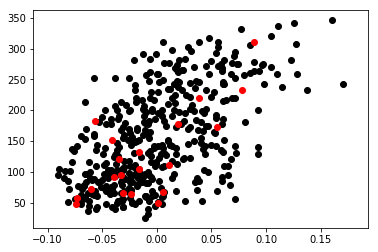

In [101]:
diabetes_X=diabetes.data[:, np.newaxis, 2]
diabetes_X_train=diabetes_X[:-20]

diabetes_X_test=diabetes_X[-20:]
diabetes_y_train=np.array(diabetes.target[:-20]).T
diabetes_y_test=np.array(diabetes.target[-20:]).T
plt.scatter(diabetes_X_train,diabetes_y_train,color="black")
plt.scatter(diabetes_X_test,diabetes_y_test,color="red")

In [102]:
diabetes_y_train=np.matrix(diabetes.target[:-20]).T
diabetes_y_test=np.matrix(diabetes.target[-20:]).T

In [122]:
script="""
ones=matrix(1,rows=nrow(X),cols=1)
X=cbind(X,ones)
A=t(X) %*% X
b=t(X) %*% y
w=solve(A,b)
bias=as.scalar(w[nrow(w),])
w=w[1:nrow(w)-1,1]
"""



In [123]:
prog=dml(script).input(X=diabetes_X_train,y=diabetes_y_train).output('w','bias')
w,bias=ml.execute(prog).get('w','bias')
w=w.toNumPy()


SystemML Statistics:
Total execution time:		0.001 sec.
Number of executed Spark inst:	2.




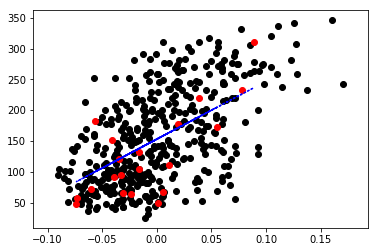

In [124]:
plt.scatter(diabetes_X_train,np.array(diabetes_y_train),color="black")
plt.scatter(diabetes_X_test,np.array(diabetes_y_test),color="red")
plt.plot(diabetes_X_test,(w*diabetes_X_test+bias),color="blue",linestyle="dotted")

# Algorithm 2: Stochastic Gradient Descent

In [129]:
script="""
    ones = matrix(1,rows=nrow(X),cols=1)
    X = cbind(X,ones)
    w = matrix(0,rows=ncol(X),cols=1)
    XtX = t(X)%*%X
    max_iter=100
    for (i in 1:max_iter){
    
        dw = XtX %*% w - t(X) %*% y
        alpha = (t(dw)%*%dw) / (t(dw)%*%XtX%*%dw)
        w = w - dw * alpha
    }
    bias=as.scalar(w[nrow(w),1])
    w=w[1:nrow(w)-1,]
"""

In [134]:
prog=dml(script).input(X=diabetes_X_train,y=diabetes_y_train).output('w').output('bias')
w,bias= ml.execute(prog).get('w','bias')
w = w.toNumPy()


SystemML Statistics:
Total execution time:		0.025 sec.
Number of executed Spark inst:	2.




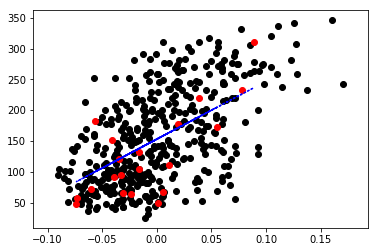

In [135]:
plt.scatter(diabetes_X_train,np.array(diabetes_y_train),color="black")
plt.scatter(diabetes_X_test,np.array(diabetes_y_test),color="red")
plt.plot(diabetes_X_test,(w*diabetes_X_test+bias),color="blue",linestyle="dotted")